In [36]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import numpy as np
from transformers import ViTImageProcessor, AutoModel, AutoTokenizer, CLIPProcessor, TrainingArguments, Trainer
from dataclasses import dataclass
from matplotlib import pyplot as plt
from safetensors.torch import load_file
import torch.nn.functional as F
import albumentations as A
from catboost import CatBoostClassifier, Pool

from tqdm import tqdm
tqdm.pandas()


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
train = pd.read_csv("balanced_train.csv")
test = pd.read_csv('test_df.tsv', sep='\t')

In [39]:
# import numpy as np
# from PIL import Image
# from pathlib import Path

# def is_image_ok(path: Path, min_size=10) -> bool:
#     try:
#         with Image.open(path) as img:
#             img.load()  # фактическая загрузка пикселей
#             arr = np.array(img)
#         h, w = arr.shape[:2]
#         if h < min_size or w < min_size:
#             return False
#         if arr.ndim != 3 or arr.shape[2] not in (1, 3, 4):
#             return False  # странные каналы
#         with Image.open(path) as img:
#             img.convert("RGB")
#         return True
#     except Exception:
#         return False

# test_mask = test['filename'].progress_apply(lambda f: is_image_ok(Path('test')/f.replace(":", "_")))


In [40]:
# train_mask.to_csv("train_mask.csv")
# train_mask = pd.read_csv("train_mask.csv", index_col=0)
test_mask = pd.read_csv("test_mask.csv", index_col=0)

In [41]:
train.shape

(35692, 3)

In [42]:
CLIP_train = train[train['mark'] == 'Идеально']

In [43]:
X = CLIP_train.drop(columns=['mark'])
y = CLIP_train['mark']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.05, random_state=42)

In [44]:
# train.to_csv("real_train.csv")

In [45]:
text_model_name = "sentence-transformers/clip-ViT-B-32-multilingual-v1"
image_model_name = "clip-ViT-B-32"

In [46]:
class CustomDataset(Dataset):
    def __init__(
        self, X, y, images_root,
        image_processor, tokenizer,
        max_length=256, transform=None
    ):
        self.X = X.reset_index(drop=True)
        self.images_root = Path(images_root)
        self.image_processor = image_processor
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X.iloc[idx]
        filename = row["filename"].replace(":", "_")
        img_path = self.images_root / filename
        caption = row["text"]

        image = Image.open(img_path)
        if image.mode != "RGB":
            image = image.convert("RGB")

        if self.transform:
            # если transform = albumentations
            if hasattr(self.transform, "__call__") and \
               "image" in self.transform.__code__.co_varnames:
                image = np.array(image)
                image = self.transform(image=image)["image"]
            else:  # torchvision.transforms
                image = self.transform(image)

        image_inputs = self.image_processor(
            image,
            return_tensors="pt"
        )

        text_inputs = self.tokenizer(
            caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        )

        return {
            "pixel_values": image_inputs.pixel_values[0],       # [3, H, W]
            "input_ids": text_inputs.input_ids[0],              # [seq_len]
            "attention_mask": text_inputs.attention_mask[0],    # [seq_len]
            "text": caption,
            "filename": filename
        }


In [47]:
# train_transform = A.Compose([
#     # --- геометрия ---
#     A.RandomResizedCrop(224, 224, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0),
#     A.HorizontalFlip(p=0.5),
#     A.ShiftScaleRotate(
#         shift_limit=0.05, scale_limit=0.1, rotate_limit=15,
#         border_mode=0, p=0.5
#     ),

#     # --- цвет и свет ---
#     A.ColorJitter(
#         brightness=0.2, contrast=0.2,
#         saturation=0.2, hue=0.1, p=0.7
#     ),
#     A.RandomBrightnessContrast(
#         brightness_limit=0.2, contrast_limit=0.2, p=0.5
#     ),
#     A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),

#     # --- шумы и артефакты ---
#     A.GaussianBlur(blur_limit=(3, 7), p=0.3),
#     A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
#     A.JpegCompression(quality_lower=70, quality_upper=100, p=0.3),
# ])


In [48]:
class TextEncoder(nn.Module):
    def __init__(self, base_model, out_dim=768):
        super().__init__()
        self.base = base_model
        self.proj = nn.Linear(1024, out_dim)

    def forward(self, input_ids, attention_mask):
        out = self.base(input_ids=input_ids, attention_mask=attention_mask)
        # возьмём pooler_output или среднее по токенам
        emb = out.pooler_output
        return self.proj(emb)

In [49]:
tokenizer = AutoTokenizer.from_pretrained(text_model_name)

In [50]:
image_processor = ViTImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [51]:
CLIP_train_dataset = CustomDataset(X_train, y_train, "train", image_processor, tokenizer)
CLIP_val_dataset = CustomDataset(X_val, y_val, "train", image_processor, tokenizer)

In [52]:
@dataclass
class ClipOutput:
    image_embeds: torch.FloatTensor
    text_embeds:  torch.FloatTensor


class CustomCLIPModel(nn.Module):
    def __init__(self, image_model, text_model):
        super().__init__()
        self.image_model = image_model
        self.text_model = text_model
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1/0.07))

    def forward(self, pixel_values, input_ids, attention_mask):
        img_embs = self.image_model(pixel_values=pixel_values).pooler_output
        text_embs = self.text_model(input_ids=input_ids,
                                    attention_mask=attention_mask).last_hidden_state[:, 0]
        img_embs = F.normalize(img_embs, dim=-1)
        text_embs = F.normalize(text_embs, dim=-1)
        return ClipOutput(
            image_embeds=img_embs,
            text_embeds=text_embs
        )
    
    def get_image_features(self, pixel_values):
        return self.image_model(pixel_values=pixel_values).pooler_output
    
    def get_text_features(self, input_ids, attention_mask):
        return self.text_model(input_ids=input_ids,
                               attention_mask=attention_mask).last_hidden_state[:, 0]

In [19]:
text_model = AutoModel.from_pretrained(
    text_model_name
)
img_model = AutoModel.from_pretrained(
    "openai/clip-vit-base-patch32",
    use_safetensors=True
).vision_model
model = CustomCLIPModel(img_model, text_model).to(device)

In [20]:
def clip_loss(image_embeds, text_embeds, temperature):
    logits = (image_embeds @ text_embeds.t()) * temperature
    labels = torch.arange(logits.size(0), device=logits.device)
    loss_i2t = nn.CrossEntropyLoss()(logits, labels)
    loss_t2i = nn.CrossEntropyLoss()(logits.t(), labels)
    return (loss_i2t + loss_t2i) / 2.0

In [21]:
class MyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        loss = clip_loss(outputs.image_embeds, outputs.text_embeds, model.logit_scale)
        return (loss, outputs) if return_outputs else loss

    def prediction_step(
        self, model, inputs, prediction_loss_only=False, ignore_keys=None
    ):
        model.eval()
        with torch.inference_mode():
            inputs = self._prepare_inputs(inputs)
            outputs = model(**inputs)          # логиты
            loss = clip_loss(outputs.image_embeds, outputs.text_embeds, model.logit_scale)
            if prediction_loss_only:
                return (loss, None, None)
            return (loss, outputs, None)

In [22]:
# используйте эти параметры обучения
training_args = TrainingArguments(
    # Основные параметры
    output_dir='./CLIP_vit_berta_multilingual',  # Директория для сохранения
    
    # Параметры обучения
    num_train_epochs=5,                     # Количество эпох
    per_device_train_batch_size=32,         # Размер батча для обучения
    per_device_eval_batch_size=32,          # Размер батча для валидации
    learning_rate=3e-5,                     # Learning rate
    warmup_ratio = 0.1,                     # 10% от общего числа шагов для вармапа или warmup_steps = int(0.1 * total_training_steps)
    lr_scheduler_type = 'cosine',           # Можете посмотреть на них в 
                                            # https://www.kaggle.com/code/snnclsr/learning-rate-schedulers 
                                            # соответсвующий ему будет get_cosine_schedule_with_warmup
    gradient_accumulation_steps=4,
    # Сохранение и логирование
    logging_dir='./logs',                   # Директория для логов
    logging_steps=20,                      # Частота логирования
    save_steps=130,                         # Частота сохранения
    save_total_limit=2,                     # Максимум чекпоинтов
    save_strategy='steps',                  # Стратегия сохранения
    
    # Валидация
    eval_strategy='steps',
    eval_steps=130,            # Стратегия валидации
    load_best_model_at_end=True,            # Загружать лучшую модель
    # metric_for_best_model='weighted_f1',
    greater_is_better=True,                 # Больше значение = лучше
    # воспроизводимость
    seed=42,                                # Seed для воспроизводимости
)

In [23]:
# state_dict = load_file("vit_berta/checkpoint-1260/model.safetensors")
# model.load_state_dict(state_dict, strict=False)

In [24]:
for param in model.parameters():
    param.requires_grad = True
model.train()

CustomCLIPModel(
  (image_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
         

In [ ]:
# trainer = MyTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=CLIP_train_dataset,
#     eval_dataset=CLIP_val_dataset,
# )

In [ ]:
# trainer.train()

Step,Training Loss,Validation Loss
130,2.458700,2.423607
260,2.071800,2.278677
390,1.874400,2.214908


TrainOutput(global_step=445, training_loss=2.269668041186386, metrics={'train_runtime': 2597.2799, 'train_samples_per_second': 21.875, 'train_steps_per_second': 0.171, 'total_flos': 0.0, 'train_loss': 2.269668041186386, 'epoch': 5.0})

In [27]:
torch.cuda.empty_cache()

In [53]:
test_text_model = AutoModel.from_pretrained(
    text_model_name
)
test_img_model = AutoModel.from_pretrained(
    "openai/clip-vit-base-patch32",
    use_safetensors=True
).vision_model
test_model = CustomCLIPModel(test_img_model, test_text_model)

In [54]:
state_dict = load_file("CLIP_vit_berta_multilingual/checkpoint-445/model.safetensors")
test_model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

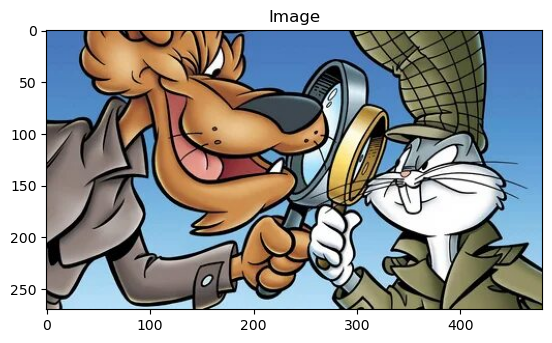

Истинный caption: полицейский луни тюнз
Лучший найденный: полицейский луни тюнз


In [72]:
test_model.eval()
test_model.to(device)

def encode_image(img: Image.Image):
    inputs = image_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = test_model.get_image_features(inputs.pixel_values)
        emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.cpu()

def encode_texts(texts):
    inputs = tokenizer(
            texts, 
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=256
        ).to(device)
    with torch.no_grad():
        emb = test_model.text_model(input_ids=inputs.input_ids,
                               attention_mask=inputs.attention_mask).last_hidden_state[:, 0]
        emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.cpu()

sample = X_val.sample(20).iloc[0]
img = Image.open('train' + '/' + sample['filename'].replace(':', '_')).convert("RGB")

im = Image.open('train' + '/' + sample['filename'].replace(':', '_'))
plt.imshow(im)
plt.title("Image")
plt.show()

true_caption = sample['text']

candidates = [
    true_caption,
    "машина стоит очти боком рисунок полицейская",
    "выходные и праздничные дни в 2020",
    "рыба приготовленная фото",
    "snack attack 4 grade",
    "картинки день флага крыма"
]

img_emb = encode_image(img)
txt_embs = encode_texts(candidates)
sims = (img_emb @ txt_embs.T).squeeze(0)
best_idx = sims.argmax().item()

print("Истинный caption:", true_caption)
print("Лучший найденный:", candidates[best_idx])


In [73]:
sims

tensor([ 0.9032,  0.5593, -0.3617, -0.0865,  0.0950, -0.1959])

In [74]:
X = train.drop(columns=['mark'])
y = train['mark']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [75]:
train_dataset = CustomDataset(X_train, y_train, "train", image_processor, tokenizer)
val_dataset = CustomDataset(X_val, y_val, "train", image_processor, tokenizer)

In [82]:
def collate_fn(batch):
    return {
        "input_ids": torch.stack([b['input_ids'] for b in batch]),
        "attention_mask": torch.stack([b['attention_mask'] for b in batch]),
        "pixel_values": torch.stack([b['pixel_values'] for b in batch]),
    }

In [83]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn, num_workers=0)

In [84]:
def compute_embeddings_and_cosine(loader):
    img_list, txt_list, cos_list = [], [], []

    with torch.no_grad():
        for batch in tqdm(loader):
            # переносим входы на GPU
            batch = {k: v.to(device) for k, v in batch.items()}

            # считаем эмбеддинги
            img = test_model.get_image_features(batch["pixel_values"])
            txt = test_model.get_text_features(batch["input_ids"],
                                               batch["attention_mask"])

            # L2-нормализация (как в CLIP)
            img = F.normalize(img, p=2, dim=1)
            txt = F.normalize(txt, p=2, dim=1)

            # косинусная схожесть
            cos = F.cosine_similarity(img, txt, dim=1)

            # переносим на CPU и сразу в список
            img_list.append(img.cpu())
            txt_list.append(txt.cpu())
            cos_list.append(cos.cpu())

            # освобождаем GPU-память
            del img, txt, cos
            torch.cuda.empty_cache()

    # объединяем по батчам
    img_all = torch.cat(img_list).numpy()
    txt_all = torch.cat(txt_list).numpy()
    cos_all = torch.cat(cos_list).numpy()

    return img_all, txt_all, cos_all


In [85]:
train_img, train_txt, train_cos = compute_embeddings_and_cosine(train_loader)
val_img, val_txt, val_cos = compute_embeddings_and_cosine(val_loader)

100%|██████████| 28/28 [01:56<00:00,  4.14s/it]


In [86]:
d_img, d_txt = train_img.shape[1], train_txt.shape[1]
columns = (
    [f"img_{i}" for i in range(d_img)] +
    [f"txt_{i}" for i in range(d_txt)] +
    ["cosine_sim"]
)

# Склеиваем уже готовые numpy-массивы
train_all = np.concatenate(
    [train_img, train_txt, train_cos.reshape(-1, 1)],
    axis=1
)
val_all = np.concatenate(
    [val_img, val_txt, val_cos.reshape(-1, 1)],
    axis=1
)

X_train_processed = pd.DataFrame(train_all, columns=columns)
X_val_processed   = pd.DataFrame(val_all,   columns=columns)


In [1]:
X_train_processed.to_csv("X_train_processed.csv", index=False)

NameError: name 'X_train_processed' is not defined

In [ ]:
X_val_processed.to_csv("X_val_processed.csv", index=False)

In [87]:
train_pool = Pool(X_train_processed, label=y_train)
val_pool = Pool(X_val_processed, label=y_val)

catboost_model = CatBoostClassifier(
    iterations=500,
    depth=5,
    learning_rate=0.05,
    early_stopping_rounds=500,
    loss_function="MultiClass",
    eval_metric="Accuracy",
    verbose=100,
    random_seed=42,
    task_type="GPU" if torch.cuda.is_available() else "CPU"
)

catboost_model.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7929456	test: 0.7885154	best: 0.7885154 (0)	total: 103ms	remaining: 51.3s
100:	learn: 0.8216176	test: 0.8078431	best: 0.8117647 (85)	total: 1.35s	remaining: 5.32s
200:	learn: 0.8339145	test: 0.8142857	best: 0.8142857 (200)	total: 2.63s	remaining: 3.91s
300:	learn: 0.8422265	test: 0.8168067	best: 0.8170868 (259)	total: 3.88s	remaining: 2.57s
400:	learn: 0.8487641	test: 0.8184874	best: 0.8184874 (398)	total: 5.12s	remaining: 1.26s
499:	learn: 0.8553639	test: 0.8176471	best: 0.8198880 (410)	total: 6.36s	remaining: 0us
bestTest = 0.8198879552
bestIteration = 410
Shrink model to first 411 iterations.


In [88]:
catboost_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,cosine_sim,59.697111
1,img_295,0.748259
2,txt_274,0.699994
3,txt_208,0.537608
4,txt_736,0.402831
...,...,...
1532,txt_756,0.000000
1533,txt_757,0.000000
1534,txt_760,0.000000
1535,txt_762,0.000000


In [89]:
test.loc[~test_mask["filename"], "filename"] = test["filename"].iloc[0]

In [90]:
X_test = test.drop(columns=['mark'])
y_test = test['mark']

In [91]:
test_dataset = CustomDataset(X_test, y_test, "test", image_processor, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn, num_workers=0)

In [92]:
test_img, test_txt, test_cos = compute_embeddings_and_cosine(test_loader)
test_all = np.concatenate(
    [test_img, test_txt, test_cos.reshape(-1, 1)],
    axis=1
)

100%|██████████| 94/94 [07:17<00:00,  4.66s/it]


In [93]:
X_test_processed = pd.DataFrame(test_all, columns=columns)
test_pool = Pool(X_test_processed, label=test["mark"])

In [ ]:
X_test_processed.to_csv("X_test_processed.csv", index=False)

In [94]:
predictions = catboost_model.predict(test_pool)

In [95]:
submission = pd.DataFrame()
submission["filename"] = test["filename"]
submission['text'] = test['text']
submission["mark"] = predictions.flatten()

In [96]:
submission.loc[~test_mask.iloc[:, 0], "mark"] = test.loc[~test_mask.iloc[:, 0], "mark"]

In [97]:
submission.to_csv("predictions4.tsv", sep="\t", index=False)

In [98]:
submission

,filename,text,mark
0,competition_data:46008.png,диаграмма при аритмии сердца,Удовлетворительно
1,competition_data:354303.png,оборона полоцка в 1941 году,Идеально
2,competition_data:98673.png,короба под инсталляцию,Удовлетворительно
3,competition_data:208734.png,раскраски энчантималс,Идеально
4,competition_data:260487.png,дани милохина,Идеально
...,...,...,...
11995,competition_data:85036.png,проект мой город 2 класс окружающий мир,Удовлетворительно
11996,competition_data:333914.png,страны и заповедникиподмосковье,Удовлетворительно
11997,competition_data:97622.png,принцип обеспечивающий единство общего специал...,Удовлетворительно
11998,competition_data:237715.png,инн огрн 440008 г пенза ул ставского 11,Удовлетворительно


In [ ]:
def generate_negative_samples(model, dataloader, device='cuda', top_k=1):
    model.eval()
    model.to(device)

    all_image_embs, all_text_embs = [], []
    texts, filenames = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # всё переносим на нужное устройство
            pixel_values = batch['pixel_values'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)

            # извлекаем признаки
            img_embs = F.normalize(model.get_image_features(pixel_values), dim=-1)
            txt_embs = F.normalize(model.get_text_features(input_ids, attention_mask), dim=-1)

            # добавляем к общему списку
            all_image_embs.append(img_embs)
            all_text_embs.append(txt_embs)
            texts.extend(batch['text'])
            filenames.extend(batch['filename'])

    # объединяем эмбеддинги (всё остаётся на GPU)
    all_image_embs = torch.cat(all_image_embs).to(device)
    all_text_embs = torch.cat(all_text_embs).to(device)

    # косинусные сходства (всё на одном устройстве)
    sims = all_image_embs @ all_text_embs.T

    negatives = []
    for i, fname in enumerate(filenames):
        # берём тексты с минимальной схожестью
        neg_idx = torch.argsort(sims[i], descending=False)[:top_k]
        for j in neg_idx:
            negatives.append({
                'filename': fname,
                'text': texts[j],
                'mark': 'Плохо'
            })

    torch.cuda.empty_cache()
    return negatives


In [ ]:
# negatives = generate_negative_samples(model, train_loader, device='cuda', top_k=1)
# df_neg = pd.DataFrame(negatives)

100%|██████████| 183/183 [13:40<00:00,  4.48s/it]


In [ ]:
# balanced_train = pd.concat([train, df_neg])

,filename,text,mark
0,competition_data:132892.png,календарь казахстана на 2020 год,Идеально
1,competition_data:339662.png,omar rodriguez new york,Удовлетворительно
2,competition_data:348773.png,игры из геометрических фигур в средней группе,Удовлетворительно
3,competition_data:219929.png,ахименесы,Удовлетворительно
4,competition_data:69788.png,мойдодыр чуковского стихи,Удовлетворительно
...,...,...,...
23314,competition_data_284082.png,картина петр первый битва,Неидеально
23315,competition_data_76668.png,николай николаевич константинов математика,Неидеально
23316,competition_data_156547.png,перспектива умк орксэ,Неидеально
23317,competition_data_114223.png,леонов русский лес,Неидеально


In [ ]:
# balanced_train.to_csv("balanced_train.csv", index=False)
# balanced_train

,filename,text,mark
0,competition_data:80581.png,без комплексов,Удовлетворительно
1,competition_data:32383.png,т90,Идеально
2,competition_data_235040.png,яплнская косметика,Плохо
3,competition_data_161183.png,цветное фото прокудина горского,Плохо
4,competition_data:155809.png,юлия ауг,Идеально
...,...,...,...
35687,competition_data:97167.png,поздравление с днём рождения женщине в стихах ...,Идеально
35688,competition_data:304400.png,современные диеты с точки зрения диетологии,Идеально
35689,competition_data:31993.png,как учителя применяют минутки чистописания на ...,Удовлетворительно
35690,competition_data:1192.png,макс и катя,Удовлетворительно


In [127]:
def show_random_sample(df, images_root, category="Идеально"):
    """Показывает случайный сэмпл из указанной категории."""
    subset = df[df["mark"] == category]
    if subset.empty:
        print(f"Нет примеров с меткой '{category}'")
        return

    row = subset.sample(1).iloc[0]
    img_path = Path(images_root) / row["filename"].replace(":", "_")

    try:
        image = Image.open(img_path).convert("RGB")
        display(image)
        print(f"🖼️  {row['filename']}")
        print(f"💬  {row['text']}")
        print(f"🏷️  {row['mark']}")
    except FileNotFoundError:
        print(f"Файл не найден: {img_path}")

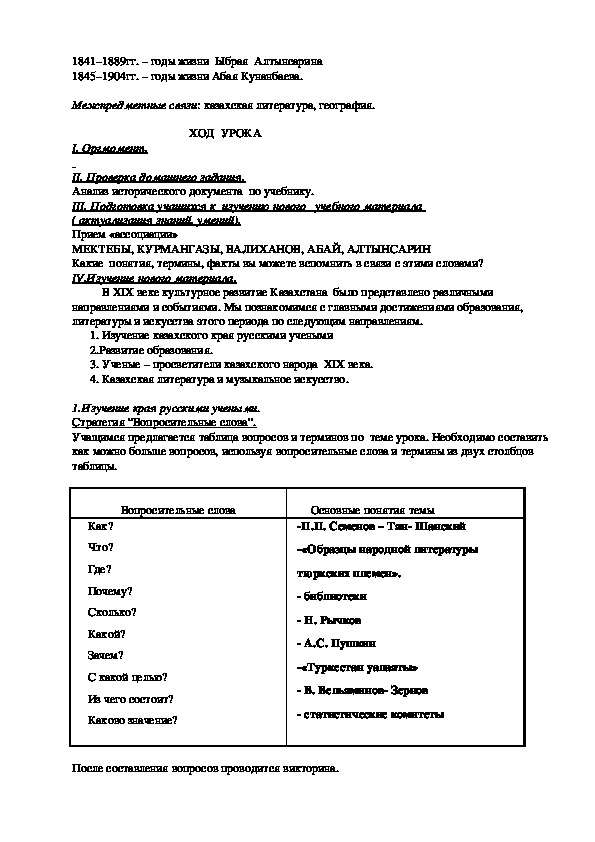

🖼️  competition_data_290313.png
💬  ambiyolar qissasi kitobi
🏷️  Плохо


In [142]:
show_random_sample(balanced_train, "train", category="Плохо")

In [ ]:
def reduce_negatives(df, negative_label="Плохо", fraction=0.33, random_state=42):
    df_pos = df[df["mark"] != negative_label]
    df_neg = df[df["mark"] == negative_label]

    # нужное количество негативов (33% от общего числа)
    target_neg_count = int(len(df_pos) * fraction / (1 - fraction))

    # если негативов слишком много — сэмплируем
    if len(df_neg) > target_neg_count:
        df_neg = df_neg.sample(target_neg_count, random_state=random_state)

    return pd.concat([df_pos, df_neg], ignore_index=True).sample(frac=1, random_state=random_state).reset_index(drop=True)


In [ ]:
# balanced_train = reduce_negatives(balanced_train)

In [101]:
import optuna
from sklearn.metrics import accuracy_score

cos = X_train_processed["cosine_sim"].values
y = np.array(y_train)

def objective(trial):
    # Сэмплируем пороги с учетом диапазона cosine_sim
    t1 = trial.suggest_float("t1", cos.min(), cos.max())
    t2 = trial.suggest_float("t2", t1, cos.max())
    
    y_pred = np.where(
        cos < t1, "Плохо",
        np.where(cos < t2, "Удовлетворительно", "Идеально")
    )
    return accuracy_score(y, y_pred)

# Настраиваем исследование
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, show_progress_bar=True)

best_t1 = study.best_params["t1"]
best_t2 = study.best_params["t2"]
best_acc = study.best_value

print(f"Лучшие пороги: t1={best_t1:.4f}, t2={best_t2:.4f}")
print(f"Accuracy = {best_acc:.4f}")

[I 2025-10-09 13:45:55,172] A new study created in memory with name: no-name-95c7925c-5d87-47fe-9d83-f24d7ab958ec


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-10-09 13:45:55,211] Trial 0 finished with value: 0.34667828902309944 and parameters: {'t1': -0.7076711260872764, 't2': -0.391149226425846}. Best is trial 0 with value: 0.34667828902309944.
[I 2025-10-09 13:45:55,234] Trial 1 finished with value: 0.6414918124649773 and parameters: {'t1': 0.46250172995795147, 't2': 0.46776935135366726}. Best is trial 1 with value: 0.6414918124649773.
[I 2025-10-09 13:45:55,255] Trial 2 finished with value: 0.6382230247182616 and parameters: {'t1': -0.2713391717649588, 't2': -0.1575844598335436}. Best is trial 1 with value: 0.6414918124649773.
[I 2025-10-09 13:45:55,274] Trial 3 finished with value: 0.6777286594857107 and parameters: {'t1': 0.0748163586024373, 't2': 0.3401540974970872}. Best is trial 3 with value: 0.6777286594857107.
[I 2025-10-09 13:45:55,294] Trial 4 finished with value: 0.6325571259572879 and parameters: {'t1': -0.296772852482756, 't2': -0.2095445636697273}. Best is trial 3 with value: 0.6777286594857107.
[I 2025-10-09 13:45:55

In [ ]:
cos_val = X_test_processed["cosine_sim"].values
y_test_pred = np.where(
    cos_val < best_t1, "Плохо",
    np.where(cos_val < best_t2, "Удовлетворительно", "Идеально")
)

In [108]:
submission = pd.DataFrame()
submission["filename"] = test["filename"]
submission['text'] = test['text']
submission["mark"] = y_test_pred.flatten()

In [109]:
submission.loc[~test_mask.iloc[:, 0], "mark"] = test.loc[~test_mask.iloc[:, 0], "mark"]

In [110]:
submission.to_csv("predictions6.tsv", sep="\t", index=False)